This notebook is a template to run impact measurements via Prophet.

In it, we will first create classes directly here (no need to import them) in the previous section, and later on run the analyses.

# **Impact Measurement with Prophet**

## **Import Libraries**

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator, MONDAY
import seaborn as sns
import plotly.express as px
import trino
import datetime
import itertools
import time
import statsmodels.api as sm
import linearmodels.panel as PanelOLS

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

c:\Users\Quim Ros\.pyenv\pyenv-win\versions\3.11.7\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trino connection (provide your credentials):

In [4]:
## Starbust credentials (this works alone, no need to modify)
HOST = 'starburst.g8s-data-platform-prod.glovoint.com'
PORT = 443
conn_details = {
    'host': HOST,
    'port': PORT,
    'http_scheme': 'https',
    'auth': trino.auth.OAuth2Authentication()
}

In [5]:
# connect to retrieve data
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query('select 1', conn)

df.head()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/23d96ad8b97fbb6147de537364ecbfea92bfbdac2a652cc9909d5350df2daa93


,_col0
0,1


## **1. Class Creation**

We will first define the Class with which the Impact Measurement Prophet script runs on.

In [6]:
class Prophet_IM:
    '''
    Class used to train a Prophet model for Impact Measurements.

    It considers methods just for base fitting and exploration, hyperparameter tuning to obtain more refined predictions, plotting and result exploration, namely comparing the actual trend vs the prediction.
    
    '''
    def __init__(self, df, x, y, intervention_date, param_grid, yearly_seasonality = True, periodicity = 'W', training_window = 94, prediction_horizon = 4, repetition_period = 2, mcmc_samples = 0):

        # Base attributes
        self.df = df
        self.intervention_date = intervention_date
        self.param_grid = param_grid # parameter grid for cross validation
        self.yearly_seasonality = yearly_seasonality
        self.periodicity = periodicity
        self.prediction_horizon = prediction_horizon
        self.repetition_period = repetition_period
        self.mcmc_samples = mcmc_samples

        if training_window > len(df) - prediction_horizon*2:
            print('You have inputted fewer data than your indicated training_window. \nBear in mind you must have as many weeks as training_window + prediction_window *2 (test + real prediction).\nWe will default your training window to length of your dataframe - prediction_horizon *2.\nBear in mind cross validation will not work in this configuration.')
            self.training_window = training_window = len(df) - prediction_horizon*2
        else:
            self.training_window = training_window

        # Modified DataFrames   
        self.formatted_df = df[[x, y]].rename({y: 'y', x:'ds'}, axis = 1).sort_values(by = 'ds') # modified dataframe to leave it in the necessary format for Prophet. Plus, order it so that our filters work later on.
        self.df_before_intervention = self.formatted_df[self.formatted_df.ds < self.intervention_date] # dataframe before intervention, used to train for the real prediciton, as well as to train-test split to train models and characterize it with a MAPE. Also useful to run CV in its whole.
        
        self.train_df = self.df_before_intervention.iloc[len(self.df_before_intervention)-self.prediction_horizon-self.training_window:-self.prediction_horizon] # select your train_df, considering the most recent, until cutoff, training_windos provided
        self.test_df = self.df_before_intervention.iloc[-self.prediction_horizon:] #test dataframe, in which to evaluate MAPE for a simple fitted model.

        # HyperParameter Tuning and model evaluation
        self.best_params = None
        self.best_model = None
        self.best_model_mape = None
        self.best_model_mape_evaluation = None
        self.fcst = None # forecast, storing the forecast of the best-performing model. Not done until calling the model_results method

    def simple_fitting(self):
        '''
        This method simply fits a model without conducting any hyperparameter tuning in order to quickly find how Prophet in the provided periodicity is able to fit the provided dataframe.
        '''
        cutoff_date = pd.Timestamp(self.intervention_date) - pd.Timedelta(self.prediction_horizon, unit=self.periodicity.upper())
        # Declare and train model
        m = Prophet(yearly_seasonality = self.yearly_seasonality).fit(self.train_df)
        # Predict
        future = m.make_future_dataframe(periods=self.prediction_horizon, freq = self.periodicity) # W = week, MS = month start
        future.ds = future.ds.apply(lambda x:x if x < cutoff_date-pd.Timedelta(1, unit="d") else x+pd.Timedelta(1, unit="d")) # apply small correction because for prophet weeks start on Sunday! Shift them to next monday. Also, cutoff_date has to be subtracted 1D because else there is a decalage due to Prophet starting weeks on Sundays
        fcst = m.predict(future) #fcst stands for forecast
        
        # Evaluate quality of prediction
        y_pred = fcst[fcst.ds >= cutoff_date]['yhat']
        y_true = self.test_df['y']
        # Obtain mape
        mape = mean_absolute_percentage_error(y_true, y_pred)
        print(f'\nMAPE: {mape}')
        
        # Store results if best performing model
        if self.best_model_mape == None or mape < self.best_model_mape:
            self.best_model_mape = mape
            self.best_model = Prophet(yearly_seasonality = self.yearly_seasonality, # save the model without fitting 
                                            interval_width = 1,# add 100% CI, not 95%, because later in the simulations we are already going to take into account the 95% CI
                                            mcmc_samples = self.mcmc_samples, # perform MCMC simulations to account for uncertainty in the seasonality. This way we'll be able to obtain a CI to notice whether the effect was statistically significant or not
                                            )
            self.best_model_mape_evaluation = 'Simple MAPE Comparison Train/Test'
            # self.best_params = m.params -> Leave it commented, as they are going to be the parameters by default, i.e., None
            print('\n----------------------------------------------------------------------------------------')
            print('Updated Model to best-performing')
            print('----------------------------------------------------------------------------------------')
        else:
            # leave it as it is
            pass
    
    def cv_and_check_cutoffs(self):
        '''
        Method to fit a simple model and check its performance via cross validation and check the number of cutoffs. Recommended cutoffs to have a more representative metric of model's performance: 3
        '''
        m = Prophet(yearly_seasonality = self.yearly_seasonality,
                    interval_width = 1, # add 100% CI, not 95%, because later in the simulations we are already going to take into account the 95% CI
                                            mcmc_samples = self.mcmc_samples, # perform MCMC simulations to account for uncertainty in the seasonality. This way we'll be able to obtain a CI to notice whether the effect was statistically significant or not
                                            ).fit(self.df_before_intervention)
        df_cv = cross_validation(m, initial=f'{self.training_window} {self.periodicity}', period=f'{self.repetition_period} {self.periodicity}', horizon = f'{self.prediction_horizon} {self.periodicity}')
        
        # Print number of cutoffs
        print(f'\nNumber of cutoffs: {df_cv.cutoff.nunique()}. Modify number of cutoffs by importing more or less data.')
        print('----------------------------------------------------------------------------------------')
        print('Performance Metrics for each Horizon:\n')
        print(performance_metrics(df_cv))
        print('----------------------------------------------------------------------------------------')
        print(f'Average MAPE: {performance_metrics(df_cv).mape.mean()}')

        # Store results if best performing model
        if self.best_model_mape == None or performance_metrics(df_cv).mape.mean() < self.best_model_mape or self.best_model_mape_evaluation == 'Simple MAPE Comparison Train/Test':
            self.best_model_mape = performance_metrics(df_cv).mape.mean()
            self.best_model = Prophet(yearly_seasonality = self.yearly_seasonality, # save the model without fitting 
                                            interval_width = 1, # add 100% CI, not 95%, because later in the simulations we are already going to take into account the 95% CI
                                            mcmc_samples = self.mcmc_samples, # perform MCMC simulations to account for uncertainty in the seasonality. This way we'll be able to obtain a CI to notice whether the effect was statistically significant or not
                                            )
            self.best_model_mape_evaluation = 'Cross Validation'
            # self.best_params = m.params -> Leave it commented, as they are going to be the parameters by default, i.e., None
            print('\n----------------------------------------------------------------------------------------')
            print('Updated Model to best-performing')
            print('----------------------------------------------------------------------------------------')
        else:
            # leave it as it is
            pass

    
    def hyperparameter_tuning(self):
        '''
        This method considers performing hyperparameter tuning with regards to the inputted parameter grid, plus evaluating via cross validation, also considering the evaluated parameters.        
        '''

        # Generate all combinations of parameters
        all_params = [dict(zip(self.param_grid.keys(), v)) for v in itertools.product(*self.param_grid.values())]
        mapes = []  # Store the MAPEs for each params here

        # Use cross validation to evaluate all parameters
        for params in all_params:
            m = Prophet(yearly_seasonality = True, **params).fit(self.df_before_intervention)  # Fit model with given params
            df_cv = cross_validation(m, initial=f'{self.training_window} {self.periodicity}', period=f'{self.repetition_period} {self.periodicity}', horizon = f'{self.prediction_horizon} {self.periodicity}', parallel="processes")
            df_p = performance_metrics(df_cv, rolling_window=1)
            mapes.append(df_p['mape'].values[0])
        
        # Find the best parameters
        tuning_results = pd.DataFrame(all_params)
        tuning_results['mape'] = mapes

        # Print results
        print('----------------------------------------------------------------------------------------')
        print('Best performing parameters:\n')
        print(tuning_results.sort_values(by = 'mape').head())
        print('----------------------------------------------------------------------------------------')
        
        # If best than the saved models so far, save parameters and model:
        best_mape = tuning_results.sort_values(by = 'mape').iloc[0]['mape']
        if best_mape < self.best_model_mape or best_mape == None or self.best_model_mape_evaluation == 'Simple MAPE Comparison Train/Test':
            self.best_model_mape = best_mape
            self.best_params = all_params[np.argmin(mapes)]
            self.best_model = Prophet(yearly_seasonality = True,
                                            interval_width = 1, # add 100% CI, not 95%, because later in the simulations we are already going to take into account the 95% CI
                                            mcmc_samples = self.mcmc_samples, # perform MCMC simulations to account for uncertainty in the seasonality. This way we'll be able to obtain a CI to notice whether the effect was statistically significant or not
                                            **self.best_params)
            self.best_model_mape_evaluation = 'Cross Validation'

            print('\n----------------------------------------------------------------------------------------')
            print('Updated Model to best-performing')
            print('----------------------------------------------------------------------------------------')

    
    def model_results(self):
        '''
        Method to plot and print the model results, and the prediction impact, acording to the best-performing model stored via previous methods
        '''

        if self.best_model == None:
            print('Please, define a model via other methods')
        else:
            
            # Fit best performing model 
            mf = self.best_model
            try:
                # if it's not fitted, fit
                mf.fit(self.df_before_intervention) # we are going to fit all data before intervention
            except:
                # if it has already been fitted, do nothing and continue running the code
                pass

            # Use the best performing model to Predict
            future = mf.make_future_dataframe(periods=self.prediction_horizon, freq = self.periodicity) # W = week, MS = month start
            future.ds = future.ds.apply(lambda x:x if x < pd.Timestamp(self.intervention_date) - pd.Timedelta(1, unit="d") else x+pd.Timedelta(1, unit="d")) # apply small correction because for prophet weeks start on Sunday! Shift them to next monday for all those missmatched weeks, starting from the sunday before the intervention week 
            fcst = mf.predict(future) #fcst stands for forecast

            # In addition, create a 95% CI Model and fit it, in order to visually represent predictions.
            # Right now, we have to fit the actual model that we will use with 100% CIs, because later we perform random simulations where we'll extract 95% CIs. We cannot retrieve twice 95% CIs, because we'd be making our dispersion smaller than it actually is.
            # However, to visually present it to stakeholders, we will present the first seasonal impact also with a 95% CI instead of a 100%, to represent the same that cumulatively we do with aggregations
            if self.best_params == None:
                m95 = Prophet(yearly_seasonality = self.yearly_seasonality,
                        interval_width = 0.95, # add 95% CI
                        mcmc_samples = self.mcmc_samples, # perform MCMC simulations to account for uncertainty in the seasonality. This way we'll be able to obtain a CI to notice whether the effect was statistically significant or not
                        )
            else:
                m95 = Prophet(yearly_seasonality = self.yearly_seasonality,
                        interval_width = 0.95, # add 95% CI
                        mcmc_samples = self.mcmc_samples, # perform MCMC simulations to account for uncertainty in the seasonality. This way we'll be able to obtain a CI to notice whether the effect was statistically significant or not
                        **self.best_params)
                
            m95.fit(self.df_before_intervention)
            future95 = m95.make_future_dataframe(periods=self.prediction_horizon, freq = self.periodicity) # W = week, MS = month start
            future95.ds = future95.ds.apply(lambda x:x if x < pd.Timestamp(self.intervention_date) - pd.Timedelta(1, unit="d") else x+pd.Timedelta(1, unit="d")) # apply small correction because for prophet weeks start on Sunday! Shift them to next monday for all those missmatched weeks, starting from the sunday before the intervention week 
            fcst95 = m95.predict(future95) #fcst stands for forecast

            # Print fitted model
            # Plots of Impact measurements are displayed with a 95% CI to be more in accordance with the 95% simulated CI prepared in the cumulative part from Prophet's 100% Ci
            print('\n-----------------------------------------------------------------------------------------------------------------------\n')
            print('\nFitted model:\n')
            fig1 = m95.plot(fcst95)
            plt.show()
            print('\n-----------------------------------------------------------------------------------------------------------------------\n')
            print('\nSeasonal trend and uncertainty:\n')
            fig2 = m95.plot_components(fcst95)
            plt.show()


            # Prepare results of Impact Measurement
            dff_plot = self.formatted_df.copy() # retrieve again the overall dataframe, with the necessary Prophet format
            fig = plt.figure(facecolor='w', figsize=(10, 6))
            ax = fig.add_subplot(111)

            # Plotting observed data points before and after intervention date
            ax.plot(dff_plot[dff_plot.ds < self.intervention_date]['ds'], dff_plot.y[dff_plot.ds < self.intervention_date], color='r', alpha=0.3) # real data before intervention
            ax.plot(dff_plot[dff_plot.ds >= self.intervention_date]['ds'], dff_plot.y[dff_plot.ds >= self.intervention_date], color='r') # real data after intervention

            # Plotting forecast and uncertainty interval
            fig1 = m95.plot(fcst95, ax=ax)

            # Adding vertical line for intervention date
            ax.axvline(x=self.intervention_date, color='k', linestyle='--')

            # Manually specifying legend labels for each plotted element
            legend_labels = ['Observations (before intervention)', 'Observations (after intervention)', 'Observed data points, used to fit model', 'Forecast', 'Uncertainty Interval', 'Intervention Date']
            ax.legend(legend_labels)

            # Print Results
            # Plots of Impact measurements are displayed with a 95% CI to be more in accordance with the 95% simulated CI prepared in the cumulative part from Prophet's 100% Ci
            print('\n\n-----------------------------------------------------------------------------------------------------------------------\n-----------------------------------------------------------------------------------------------------------------------\n\n')
            print('\nImpact Measurement Results:\n')
            plt.show()

           
           
            # Calculate Incrementality

            # First, prepare dataframe to compare forecast vs actuals (incremental values) - merged is that dataframe
            # Here we go back to retrieveing the Prophet model with 100% CI
            self.fcst = fcst.copy()
            fcst_plot = fcst.copy()
            fcst_plot.ds = fcst_plot.ds.dt.date
            merged = dff_plot[dff_plot.ds >= self.intervention_date].merge(fcst_plot[fcst_plot.ds >= self.intervention_date][['yhat', 'yhat_upper', 'yhat_lower', 'ds']], on = 'ds')

            # From the obtained forecast, we will simulate 1000 random combinations of each prediction after the intervention date, with a gaussian distribution
            # Simulated values will follow a Gaussian distribution from yhat_upper to yhat_lower, and from these w will obtain via simulations both the mean as well as the 95% CIs.
            # We will sum all the predicted simulated horizons after the intervention date.
            # Then we will average all contributions, so as to obtain cumulative incrementality as per horizon with a margin of error

            # Iter through rows (predicted horizons)
            list_random_horizons = []
            for ind, i in merged.iterrows():
                # Calculate the mean and standard deviation based on the desired CI
                mean_gaussian = (i.yhat_upper + i.yhat_lower)/2
                std_dev = (i.yhat_upper - mean_gaussian)/norm.ppf(0.975) # 95% significance splitted between both tails

                # Generate random values from a normal distribution
                random_values = np.random.normal(mean_gaussian, std_dev, 1000)  # Generating 1000 random samples

                list_random_horizons.append(random_values)
            
            # In order to visualize the cumulative effect throughout horizons, we have to make cumulative sums and averages for each of the horizons
            list_randomized_results = []
            for i in range(len(list_random_horizons)):
                # Sum randomized simulated values accross dimensions
                result = np.sum(list_random_horizons[:i+1], axis = 0)
                # Flatten the array to calculate the average
                flattened_result = result.flatten()
                # Calculate the average and the 95% CI
                average = np.average(flattened_result)
                ci_upper = np.percentile(flattened_result, 97.5) # upper 95% CI bound of the gaussian distribution
                ci_lower = np.percentile(flattened_result, 2.5) # lower 95% CI bound of the gaussian distribution

                # Calculate the equivalent increment in real-life NCs
                ys = merged.sort_values(by = 'ds').y.to_numpy()[:i+1]
                y_sum = np.sum(ys) # sum of actual values

                # Finally, retrieve the timestamp of prediction
                ds = merged.ds[i]

                # Append results 
                list_randomized_results.append((ds, average, ci_upper, ci_lower, y_sum))
            
            # Plot Cumulative results of Impact Measurements   

            cumulative_df = pd.DataFrame(list_randomized_results, columns = 'ds cumulative_prediction ci_upper ci_lower cumulative_increment'.split()) # cumulative_prediction id the cumulative sum of the prediction, 95_perc_error its error (as observed throughout simulations), and cumulative_increment the cumulative sum of actual observations
            # Create the figure and axis
            fig, ax = plt.subplots(figsize=(10, 6))

            # Plotting cumulative sums of prediction and observations
            ax.plot(cumulative_df.ds, cumulative_df.cumulative_prediction, color='#0072B2', label = 'Cumulative Sum (Prediction)') # cumulative sum of prediction
            ax.plot(cumulative_df.ds, cumulative_df.cumulative_increment, color='r', label = 'Cumulative Sum (Actual Observations)') # cumulative sum of actual observations
            # Plot the area around the prediction with the +- 95% error
            ax.fill_between(
                cumulative_df['ds'],
                cumulative_df.ci_lower,
                cumulative_df.ci_upper,
                color='#0072B2',
                alpha=0.2,
                label='95% CI'
            )

            # Adding vertical line for intervention date
            ax.axvline(x=self.intervention_date, color='k', linestyle='--', label = 'Intervention Date')
            
            # Set the title and axis labels
            ax.set_title('Cumulative Impact Accross Horizons')
            ax.set_xlabel('Date')
            ax.set_ylabel('Cumulative Sum')
            # Set the x-axis tick locator to show weeks
            ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MONDAY))
            ax.xaxis.set_major_formatter(DateFormatter('%b %d'))
            # Add legend
            ax.legend()

            # Add final scatter points ad axis 0, not in the legend
            ax.scatter(cumulative_df.ds, cumulative_df.cumulative_prediction, color = 'k') # cumulative sum of prediction, datapoints
            ax.scatter(cumulative_df.ds, cumulative_df.cumulative_increment, color = 'k') # cumulative sum of prediction, datapoints
            ax.axhline(y=0, color='k', linestyle='--')

            plt.show()

            # Final result report
            statistical_significance = 'Statistically Significant Impact' if cumulative_df.sort_values(by = 'ds', ascending = False).iloc[0].cumulative_increment > cumulative_df.sort_values(by = 'ds', ascending = False).iloc[0].ci_upper or cumulative_df.sort_values(by = 'ds', ascending = False).iloc[0].cumulative_increment < cumulative_df.sort_values(by = 'ds', ascending = False).iloc[0].ci_lower else 'Not Statistically Significative Impact'
            sum_y = cumulative_df.sort_values(by = 'ds', ascending = False).iloc[0].cumulative_increment # get latest-most value of cumulative sum (actuals)
            sum_y_hat = cumulative_df.sort_values(by = 'ds', ascending = False).iloc[0].cumulative_prediction # get latest-most value of cumulative sum (prediction)
            print('\n\n-----------------------------------------------------------------------------------------------------------------------\n-----------------------------------------------------------------------------------------------------------------------\n\n')
            print(statistical_significance)
            print('-------------------------------------------------------------')
            print(f'\nAbsolute increase: {round((sum_y - sum_y_hat), 2)}')
            print('-------------------------------------------------------------')
            print(f'\nRelative increase: {round(100*(sum_y - sum_y_hat)/sum_y_hat, 2)} %')
            print('-------------------------------------------------------------')
            print(f'MAPE: {round(100*self.best_model_mape, 2)} %')



In [108]:
class RegressionwProphetInputs:
    """
    Class to predict the results of the Impact via a regression fitted with additional variables, namely the trend and seasonality resulting from Prophet.

    Important that variable to measure has same name that the column in the original df from the extraction, and that the time variable of fcst is ds
    """
    def __init__(self, intervention_date, beginning_date, ending_date, data_extraction, fcst_result, variable_to_measure, time_variable_df,
                 trend = True, seasonality = True):
        self.intervention_date = intervention_date
        self.beginning_date = beginning_date
        self.ending_date = ending_date
        self.df = data_extraction.copy()
        self.fcst = fcst_result.copy()
        self.variable_to_measure = variable_to_measure
        self.time_variable_df = time_variable_df
        self.fit_df = None # updates if running the method
        self.trend = trend
        self.seasonality = seasonality

    
    def fit_predict(self):
        """
        Perform necessary feature engineering, fit the model, and obtain the results
        """

        # Feature Engineering

        # Filter dates for both forecast and data extraction
        df = self.df[(self.df[f'{self.time_variable_df}'] >= self.beginning_date) & (self.df[f'{self.time_variable_df}'] <= self.ending_date)].copy()
        fcst = self.fcst[(self.fcst.ds.dt.date >= pd.to_datetime(self.beginning_date).date()) & (self.fcst.ds.dt.date <= pd.to_datetime(self.ending_date).date())].copy()
        # Filter just the columns we are interested in
        df = df[[f'{self.time_variable_df}', f'{self.variable_to_measure}']]
        fcst = fcst[['ds', 'trend', 'yearly']]
        # Join
        df[f'{self.time_variable_df}'] = pd.to_datetime(df[f'{self.time_variable_df}']) # change date type to tiestamp to allow for merge with fcst
        merged = df.merge(fcst, left_on = f'{self.time_variable_df}', right_on = 'ds')
        # Drop df's time variable to leave only ds
        merged.drop(f'{self.time_variable_df}', axis = 1, inplace = True)
        # Feature Extraction - add the only dummy_variable missing
        merged['is_intervention'] = np.where(merged.ds.dt.date >= pd.to_datetime(self.intervention_date).date(), 1, 0) # flag the intervention weeks to attribute incrementality to it

        self.fit_df = merged.copy()
        
        
        # Modeling

        # Fit the model
        y = merged[f'{self.variable_to_measure}'] # define target variable
        X = merged[['trend', 'yearly', 'is_intervention']] # define independent variables
        if self.trend == False:
            X.drop('trend', axis = 1, inplace = True)
        if self.seasonality == False:
            X.drop('yearly', axis = 1, inplace = True)
        # Add a constant term to the independent variables
        X = sm.add_constant(X)
        # Create an OLS model
        model = sm.OLS(y, X)
        # Fit the model
        # results = model.fit(cov_type='HC2')
        results = model.fit(cov_type='cluster', cov_kwds={'groups': merged.is_intervention})

        print(results.summary())

        

## **2. Prophet Impact Measurement: GE**

Herein, we instantiate the Prophet_IM (Impact Measurement) class in order to generate a prediction for a GE NCs and Orders.

### **2.1. Data Import**

In [7]:
query1 = '''
select
    date(date_trunc('week', order_activated_local_at)) as week,
    count(distinct od.order_id) as orders,
    count(distinct case when od.order_is_first_delivered_order = true then od.order_id else null end) as new_customers
from delta.central_order_descriptors_odp.order_descriptors_v2 as od
where 1=1
    and od.order_country_code in ('GE')
    and date(od.order_activated_local_at) between date('2022-02-21') and date('2024-03-17')
    and od.order_final_status = 'DeliveredStatus'
    and od.order_parent_relationship_type is null
group by 1
order by 1 asc
'''

# connect to retrieve data
with trino.dbapi.connect(**conn_details) as conn:
    df = pd.read_sql_query(query1, conn)

df.head()

,week,orders,new_customers
0,2022-02-21,136537,3764
1,2022-02-28,146111,4429
2,2022-03-07,148908,6032
3,2022-03-14,144897,5797
4,2022-03-21,146476,5396


### **2.2. Declaring Hyperparameters**

In [8]:
# intervention date of the campaign
INTERVENTION_DATE = datetime.date(2024, 2, 19)

# parameter grid for hyperparameter tuning. 
# we have included the most recommended parameters and ranges to tune by Prophet documentation.
# we have not seen holidays_prior_scale generate any effect in our tests for GE NCs, but it brings up cosniderably computational time
PARAM_GRID = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    #'holidays_prior_scale':  [0.01, 0.1, 1.0, 10.0], 
    'seasonality_mode':['additive', 'multiplicative']

}


### **2.3. Measurement 1: GE NCs**

In [9]:
# Instantiate your model
# the second row of parameters has the default values, but for you to know that you can tune them.

x = Prophet_IM(df, x = 'week', y = 'new_customers', intervention_date = INTERVENTION_DATE, param_grid = PARAM_GRID,
               yearly_seasonality = True, periodicity = 'W', training_window = 94, prediction_horizon = 4, repetition_period = 2, mcmc_samples =300)

In [10]:
# Perform, with the same default parameters, a fit of a model evaluating it with CV
x.cv_and_check_cutoffs()

11:31:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██        | 00:00 Status

chain 1 |████      | 00:00 Iteration:   1 / 300 [  0%]  (Warmup)

chain 1 |██████    | 00:00 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:01 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


11:31:33 - cmdstanpy - INFO - CmdStan done processing.
11:31:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


  0%|          | 0/3 [00:00<?, ?it/s]11:31:34 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


11:31:37 - cmdstanpy - INFO - CmdStan done processing.
11:31:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 33%|███▎      | 1/3 [00:04<00:08,  4.38s/it]11:31:38 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


11:31:42 - cmdstanpy - INFO - CmdStan done processing.
11:31:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 67%|██████▋   | 2/3 [00:09<00:04,  4.75s/it]11:31:43 - cmdstanpy - INFO - CmdStan start processing




































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


11:31:46 - cmdstanpy - INFO - CmdStan done processing.
11:31:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


100%|██████████| 3/3 [00:13<00:00,  4.40s/it]



Number of cutoffs: 3. Modify number of cutoffs by importing more or less data.
----------------------------------------------------------------------------------------
Performance Metrics for each Horizon:

  horizon           mse        rmse         mae      mape     mdape     smape  \
0  7 days  24756.268027  157.341247  134.247198  0.024099  0.028837  0.024494   
1 14 days  67388.366003  259.592693  247.378684  0.049880  0.037286  0.048509   
2 21 days  24303.981246  155.897342  140.211335  0.027629  0.023200  0.027329   
3 28 days  99120.775550  314.834521  307.325287  0.065154  0.066811  0.062985   

   coverage  
0       1.0  
1       1.0  
2       1.0  
3       1.0  
----------------------------------------------------------------------------------------
Average MAPE: 0.04169060172343474

----------------------------------------------------------------------------------------
Updated Model to best-performing
----------------------------------------------------------------------

In [11]:
# Perform hyperparameter tuning with the provided parameter grid to find a best-performing model
x.hyperparameter_tuning()

11:31:47 - cmdstanpy - INFO - Chain [1] start processing


11:31:47 - cmdstanpy - INFO - Chain [1] done processing
11:31:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:31:47 - cmdstanpy - INFO - Chain [1] start processing
11:31:48 - cmdstanpy - INFO - Chain [1] done processing
11:31:54 - cmdstanpy - INFO - Chain [1] start processing
11:31:54 - cmdstanpy - INFO - Chain [1] done processing
11:31:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:31:54 - cmdstanpy - INFO - Chain [1] start processing
11:31:54 - cmdstanpy - INFO - Chain [1] done processing
11:32:02 - cmdstanpy - INFO - Chain [1] start processing
11:32:02 - cmdstanpy - INFO - Chain [1] done processing
11:32:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:32:02 - cmdstanpy - I

----------------------------------------------------------------------------------------
Best performing parameters:

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
6                     0.001                     10.0         additive   
7                     0.001                     10.0   multiplicative   
3                     0.001                      0.1   multiplicative   
15                    0.010                     10.0   multiplicative   
28                    0.500                      1.0         additive   

        mape  
6   0.033158  
7   0.033600  
3   0.033667  
15  0.033939  
28  0.034355  
----------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------
Updated Model to best-performing
----------------------------------------------------------------------------------------


In [12]:
# After Hyperparameter tuning, the model has updated again to the best performing model.
# You can access easily its parameters and MAPE
print(x.best_params)
print(x.best_model_mape)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}
0.03315832372865988


11:34:59 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██        | 00:00 Status




chain 1 |████      | 00:06 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:07 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:08 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     


11:35:09 - cmdstanpy - INFO - CmdStan done processing.
11:35:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


11:35:10 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██        | 00:00 Status




chain 1 |██████    | 00:06 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |██████████| 00:09 Iteration: 250 / 300 [ 83%]  (Sampling)





chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     


11:35:22 - cmdstanpy - INFO - CmdStan done processing.
11:35:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!




-----------------------------------------------------------------------------------------------------------------------


Fitted model:



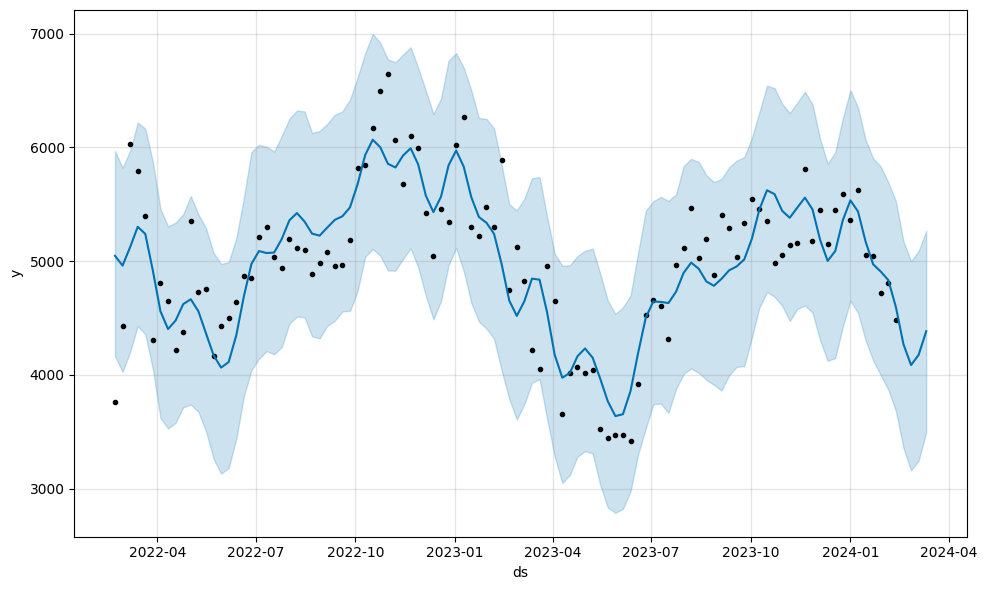


-----------------------------------------------------------------------------------------------------------------------


Seasonal trend and uncertainty:



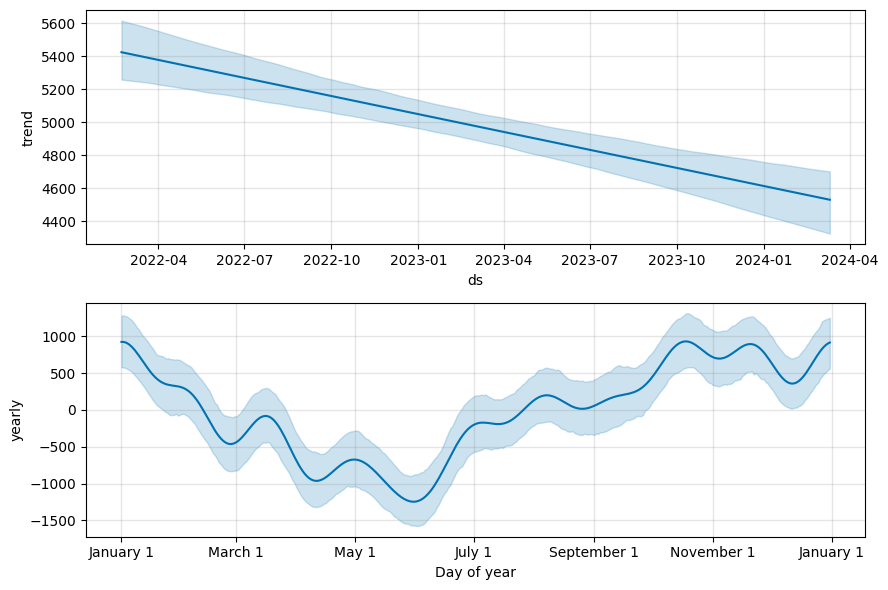



-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------



Impact Measurement Results:



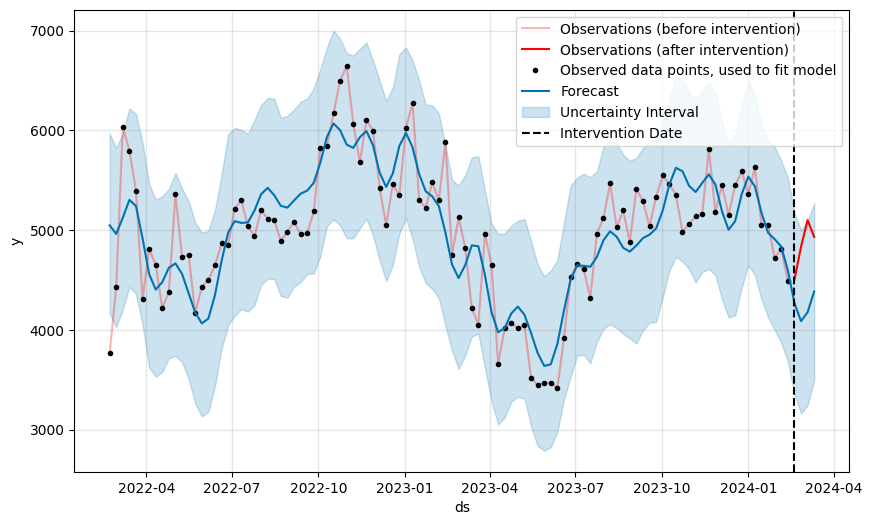

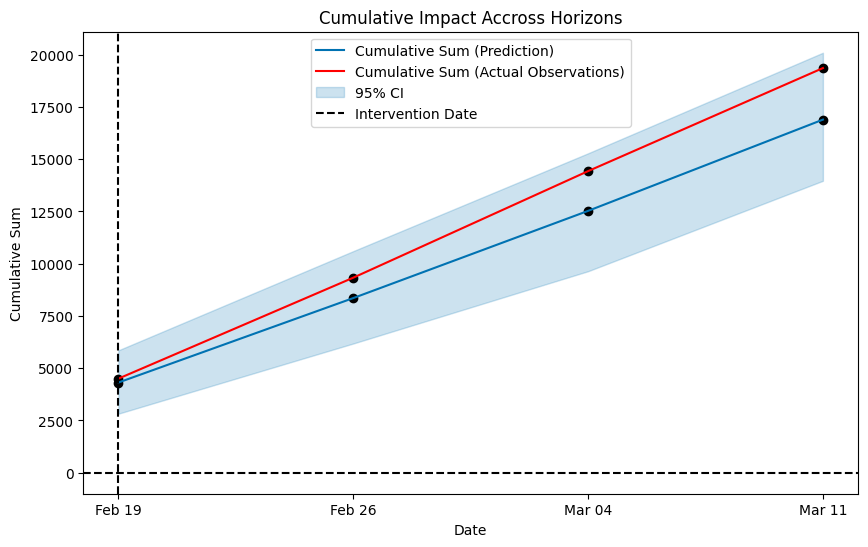



-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------


Not Statistically Significative Impact
-------------------------------------------------------------

Absolute increase: 2466.83
-------------------------------------------------------------

Relative increase: 14.6 %
-------------------------------------------------------------
MAPE: 3.32 %


In [13]:
# Now, you cna get a reading of the best-performing model results concerning Impact Measurement:
x.model_results()


#### **2.3.1. Regression fitting with Prophet's trend and seasonality**

We will fit a regression with 4 variables: Timestamp, NCs (or whatever target metric), the seasonality extracted from the prophet model, and the trend from prophet model, plus a dummy variable: if there was an impact or not.

**Fitting a Regression Model**

In [109]:
# we will get the values for 8 weeks prior to the intervention date, and 4 weeks after intervention (including the same intervention week) to prepare the model
print(INTERVENTION_DATE)
beginning_date = datetime.date(2023, 10, 16)
ending_date = datetime.date(2024, 3, 11)

2024-02-19


In [110]:
r = RegressionwProphetInputs(
    intervention_date = INTERVENTION_DATE,
    beginning_date = beginning_date,
    ending_date = ending_date,
    data_extraction = df,
    fcst_result = x.fcst,
    variable_to_measure = 'new_customers', # important that it has the same name as in df
    time_variable_df = 'week', # important that it has the same name as in df
    trend = False, # first better
    seasonality = True
)

In [111]:
r.fit_predict()

                            OLS Regression Results                            
Dep. Variable:          new_customers   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     19.31
Date:                Tue, 30 Apr 2024   Prob (F-statistic):              0.142
Time:                        12:08:26   Log-Likelihood:                -152.31
No. Observations:                  22   AIC:                             310.6
Df Residuals:                      19   BIC:                             313.9
Df Model:                           2                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4704.3740     57.435     

increase = 377/4704 = **ca. 8%** incrementality, statistically significative

### **2.4. Measurement 2: GE Orders**

In [117]:
# Instantiate your model
# the second row of parameters has the default values, but for you to know that you can tune them.

x = Prophet_IM(df, x = 'week', y = 'orders', intervention_date = INTERVENTION_DATE, param_grid = PARAM_GRID,
               yearly_seasonality = True, periodicity = 'W', training_window = 94, prediction_horizon = 4, repetition_period = 2, mcmc_samples = 300)

In [118]:
# Perform, with the same default parameters, a fit of a model evaluating it with CV
x.cv_and_check_cutoffs()

12:08:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:   1 / 300 [  0%]  (Warmup)



chain 1 |██████    | 00:01 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:02 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


12:08:59 - cmdstanpy - INFO - CmdStan done processing.
12:08:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


  0%|          | 0/3 [00:00<?, ?it/s]12:08:59 - cmdstanpy - INFO - CmdStan start processing































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


12:09:03 - cmdstanpy - INFO - CmdStan done processing.
12:09:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 33%|███▎      | 1/3 [00:03<00:07,  4.00s/it]12:09:03 - cmdstanpy - INFO - CmdStan start processing



































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


12:09:06 - cmdstanpy - INFO - CmdStan done processing.
12:09:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


 67%|██████▋   | 2/3 [00:07<00:03,  3.78s/it]12:09:07 - cmdstanpy - INFO - CmdStan start processing

































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


12:09:10 - cmdstanpy - INFO - CmdStan done processing.
12:09:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


100%|██████████| 3/3 [00:11<00:00,  3.71s/it]


Number of cutoffs: 3. Modify number of cutoffs by importing more or less data.
----------------------------------------------------------------------------------------
Performance Metrics for each Horizon:

  horizon           mse          rmse           mae      mape     mdape  \
0  7 days  1.404108e+08  11849.507567  10520.463719  0.058501  0.072999   
1 14 days  3.036809e+08  17426.443642  15594.129308  0.099374  0.075349   
2 21 days  4.362380e+07   6604.831896   6423.438163  0.036296  0.036508   
3 28 days  4.906896e+07   7004.923742   6061.975269  0.034480  0.031002   

      smape  coverage  
0  0.060678  1.000000  
1  0.095041  0.666667  
2  0.036275  1.000000  
3  0.034020  1.000000  
----------------------------------------------------------------------------------------
Average MAPE: 0.0571626613836225

----------------------------------------------------------------------------------------
Updated Model to best-performing
---------------------------------------------------

In [119]:
# Perform hyperparameter tuning with the provided parameter grid to find a best-performing model
# x.hyperparameter_tuning()

In [120]:
# After Hyperparameter tuning, the model has updated again to the best performing model.
# You can access easily its parameters and MAPE
print(x.best_params)
print(x.best_model_mape)

None
0.0571626613836225


12:09:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:01 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:02 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


12:09:21 - cmdstanpy - INFO - CmdStan done processing.
12:09:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


12:09:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |████      | 00:00 Iteration:   1 / 300 [  0%]  (Warmup)




chain 1 |██████    | 00:01 Iteration: 100 / 300 [ 33%]  (Warmup)




chain 1 |████████  | 00:02 Iteration: 151 / 300 [ 50%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


12:09:25 - cmdstanpy - INFO - CmdStan done processing.
12:09:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!




-----------------------------------------------------------------------------------------------------------------------


Fitted model:



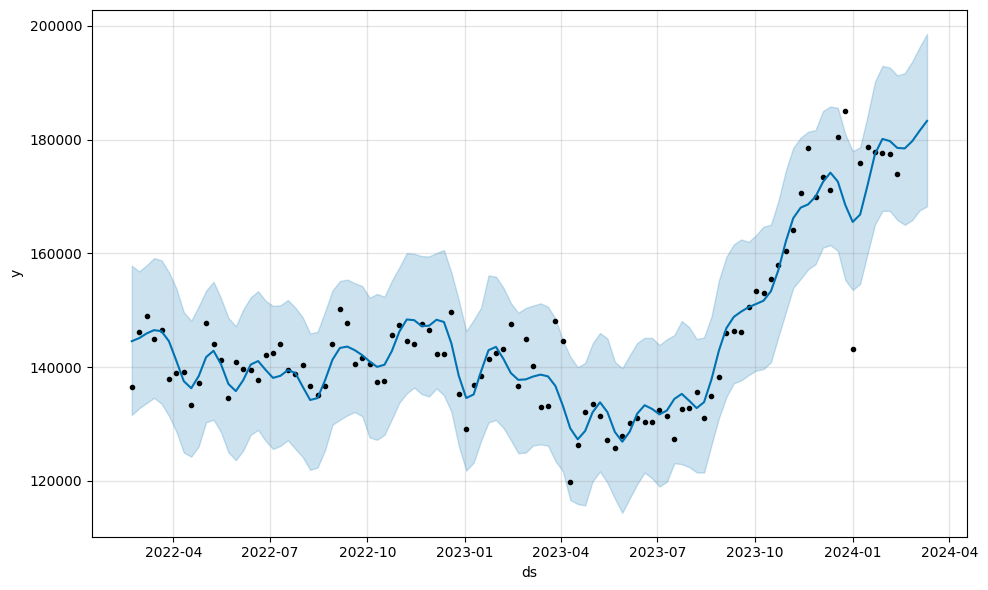


-----------------------------------------------------------------------------------------------------------------------


Seasonal trend and uncertainty:



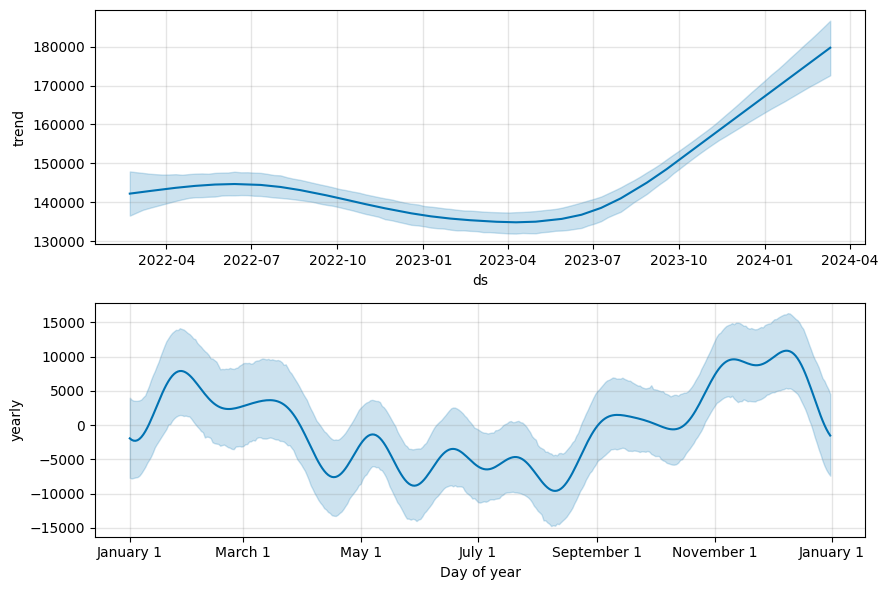



-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------



Impact Measurement Results:



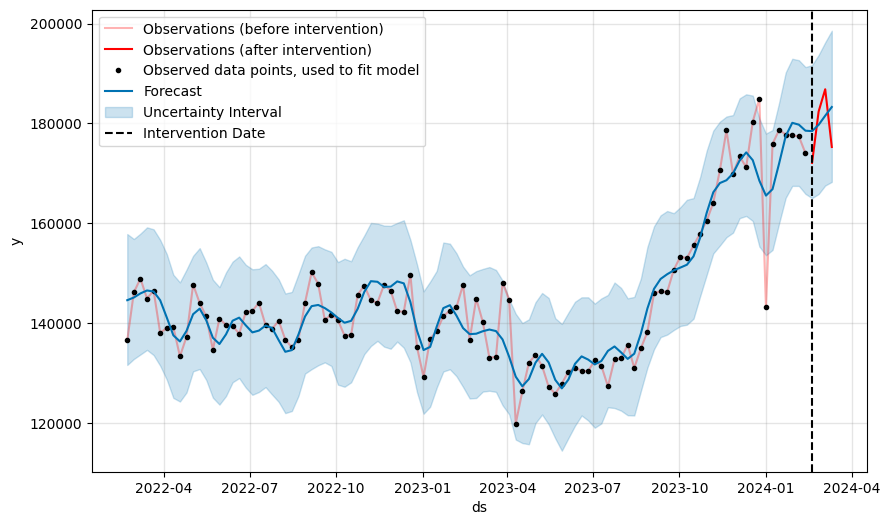

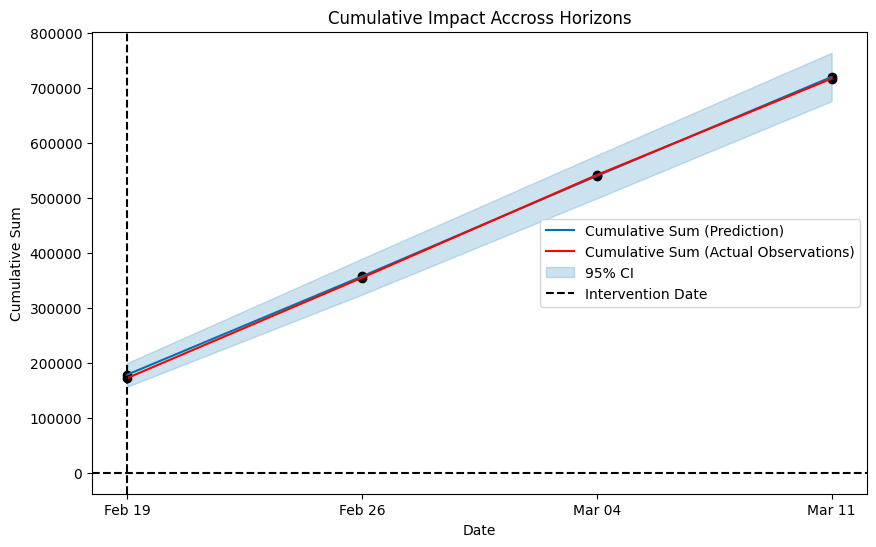



-----------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------


Not Statistically Significative Impact
-------------------------------------------------------------

Absolute increase: -3051.67
-------------------------------------------------------------

Relative increase: -0.42 %
-------------------------------------------------------------
MAPE: 5.72 %


In [121]:
# Now, you cna get a reading of the best-performing model results concerning Impact Measurement:
x.model_results()


#### **2.4.1. Regression fitting with Prophet's trend and seasonality**

We will fit a regression with 4 variables: Timestamp, NCs (or whatever target metric), the seasonality extracted from the prophet model, and the trend from prophet model, plus a dummy variable: if there was an impact or not.

**Fitting a Regression Model**

In [278]:
# we will get the values for 8 weeks prior to the intervention date, and 4 weeks after intervention (including the same intervention week) to prepare the model
print(INTERVENTION_DATE)
beginning_date = datetime.date(2023, 11, 18)
ending_date = datetime.date(2024, 3, 11)

2024-02-19


In [283]:
r = RegressionwProphetInputs(
    intervention_date = INTERVENTION_DATE,
    beginning_date = beginning_date,
    ending_date = ending_date,
    data_extraction = df,
    fcst_result = x.fcst,
    variable_to_measure = 'orders', # important that it has the same name as in df
    time_variable_df = 'week', # important that it has the same name as in df
    trend = False, # first better
    seasonality = True
)

In [284]:
r.fit_predict()

                            OLS Regression Results                            
Dep. Variable:                 orders   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                 7.774e+04
Date:                Tue, 30 Apr 2024   Prob (F-statistic):            0.00228
Time:                        12:50:08   Log-Likelihood:                -177.87
No. Observations:                  17   AIC:                             361.7
Df Residuals:                      14   BIC:                             364.2
Df Model:                           2                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.696e+05     51.942   32

<Axes: xlabel='ds'>

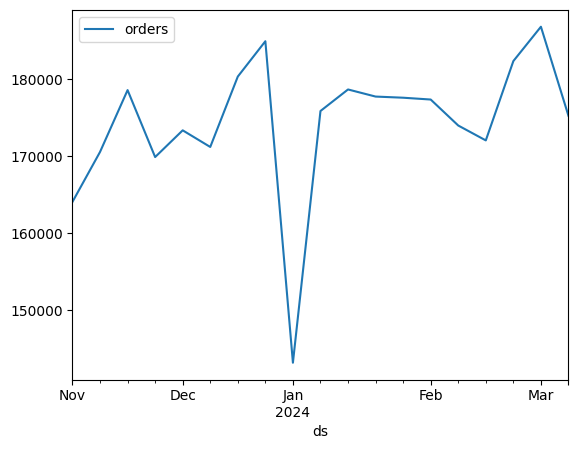

In [268]:
r.fit_df.plot(x = 'ds', y = 'orders')